In [2]:
#Source for map tuning code: https://medium.com/stereopi/opencv-and-depth-map-on-stereopi-tutorial-62cb6792bbed
# %matplotlib widget
import cv2
import os
# from picamera.array import PiRGBArray
# from picamera import PiCamera
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button
import numpy as np
import json
from stereovision.calibration import StereoCalibrator
from stereovision.calibration import StereoCalibration
import ipywidgets as wg
from IPython.display import display
from skimage import data, io, filters, morphology, segmentation, measure

Read and split image...
Read calibration data and rectifying stereo pair...
focal length:  512.0


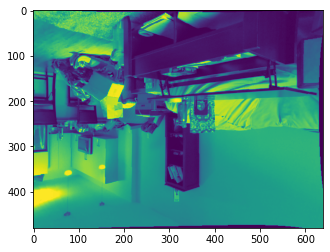

In [19]:
fig, ax = plt.subplots()
# Global variables preset
imageToDisp = './scenes/scene_1280x480_4.png'
photo_width = 1280
photo_height = 480
image_height = 480
image_width = 640
image_size = (image_width, image_height)

if os.path.isfile(imageToDisp) == False:
    print('Can not read image from file \"' + imageToDisp + '\"')
    exit(0)

pair_img = cv2.imread(imageToDisp, 0)
# Read image and split it in a stereo pair
print('Read and split image...')
imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W


# Implementing calibration data
print('Read calibration data and rectifying stereo pair...')
calibration = StereoCalibration(input_folder='calib_resultA')
rectified_pair = calibration.rectify((imgLeft, imgRight))
# rectified_pair[0] = cv2.rotate(rectified_pair[0],cv2.ROTATE_180)
# rectified_pair[1] = cv2.rotate(rectified_pair[1],cv2.ROTATE_180)
focal_length = -1*calibration.disp_to_depth_mat[2][3]
print("focal length: ", focal_length)

ax.imshow(rectified_pair[0])
#cv2.imshow('Left CALIBRATED', rectified_pair[0])
# cv2.imshow('Right CALIBRATED', rectified_pair[1])
# cv2.waitKey(0)

In [15]:
# Depth map function
SWS = 5
PFS = 5
PFC = 29
MDS = -25
NOD = 128
TTH = 100
UR = 10
SR = 15
SPWS = 100


def stereo_depth_map(rectified_pair):
    print('SWS=' + str(SWS) + ' PFS=' + str(PFS) + ' PFC=' + str(PFC) + ' MDS=' + \
          str(MDS) + ' NOD=' + str(NOD) + ' TTH=' + str(TTH))
    print(' UR=' + str(UR) + ' SR=' + str(SR) + ' SPWS=' + str(SPWS))
    c, r = rectified_pair[0].shape
    disparity = np.zeros((c, r), np.uint8)
    sbm = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    # sbm.SADWindowSize = SWS
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(PFS)
    sbm.setPreFilterCap(PFC)
    sbm.setMinDisparity(MDS)
    sbm.setNumDisparities(NOD)
    sbm.setTextureThreshold(TTH)
    sbm.setUniquenessRatio(UR)
    sbm.setSpeckleRange(SR)
    sbm.setSpeckleWindowSize(SPWS)
    dmLeft = rectified_pair[0]
    dmRight = rectified_pair[1]
    # cv2.FindStereoCorrespondenceBM(dmLeft, dmRight, disparity, sbm)
    disparity = sbm.compute(dmLeft, dmRight)
    print(disparity.shape)
    # disparity_visual = cv.CreateMat(c, r, cv.CV_8U)
    local_max = disparity.max()
    local_min = disparity.min()
    print("MAX " + str(local_max))
    print("MIN " + str(local_min))
    disparity_visual = (disparity - local_min) * (1.0 / (local_max - local_min))
    local_max = disparity_visual.max()
    local_min = disparity_visual.min()
    print("MAX " + str(local_max))
    print("MIN " + str(local_min))
    # cv.Normalize(disparity, disparity_visual, 0, 255, cv.CV_MINMAX)
    # disparity_visual = np.array(disparity_visual)
    return disparity_visual
disparity = stereo_depth_map(rectified_pair)
print(disparity.shape)


SWS=5 PFS=5 PFC=29 MDS=-25 NOD=128 TTH=100
 UR=10 SR=15 SPWS=100
(480, 640)
MAX 754
MIN -416
MAX 1.0
MIN 0.0
(480, 640)


Start interface creation (it takes up to 30 seconds)...
Show interface to user


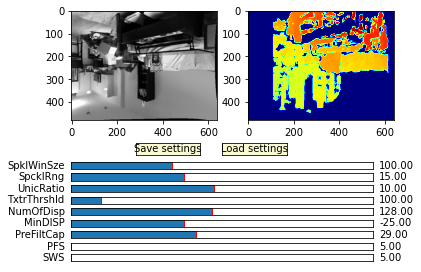

TypeError: 'AxesSubplot' object is not subscriptable

In [16]:
# Set up and draw interface
# Draw left image and depth map
axcolor = 'lightgoldenrodyellow'
fig = plt.subplots(1, 2)
plt.subplots_adjust(left=0.15, bottom=0.5)
plt.subplot(1, 2, 1)
dmObject = plt.imshow(rectified_pair[0], 'gray')

saveax = plt.axes([0.3, 0.38, 0.15, 0.04])  # stepX stepY width height
buttons = Button(saveax, 'Save settings', color=axcolor, hovercolor='0.975')
def save_map_settings(event):
    buttons.label.set_text("Saving...")
    print('Saving to file...')
    result = json.dumps({'SADWindowSize': SWS, 'preFilterSize': PFS, 'preFilterCap': PFC, \
                         'minDisparity': MDS, 'numberOfDisparities': NOD, 'textureThreshold': TTH, \
                         'uniquenessRatio': UR, 'speckleRange': SR, 'speckleWindowSize': SPWS}, \
                        sort_keys=True, indent=4, separators=(',', ':'))
    fName = '3dmap_set.txt'
    f = open(str(fName), 'w')
    f.write(result)
    f.close()
    buttons.label.set_text("Save to file")
    print('Settings saved to file ' + fName)


buttons.on_clicked(save_map_settings)
loadax = plt.axes([0.5, 0.38, 0.15, 0.04])  # stepX stepY width height
buttonl = Button(loadax, 'Load settings', color=axcolor, hovercolor='0.975')

def load_map_settings(event):
    global SWS, PFS, PFC, MDS, NOD, TTH, UR, SR, SPWS, loading_settings
    loading_settings = 1
    fName = '3dmap_set.txt'
    print('Loading parameters from file...')
    buttonl.label.set_text("Loading...")
    f = open(fName, 'r')
    data = json.load(f)
    sSWS.set_val(data['SADWindowSize'])
    sPFS.set_val(data['preFilterSize'])
    sPFC.set_val(data['preFilterCap'])
    sMDS.set_val(data['minDisparity'])
    sNOD.set_val(data['numberOfDisparities'])
    sTTH.set_val(data['textureThreshold'])
    sUR.set_val(data['uniquenessRatio'])
    sSR.set_val(data['speckleRange'])
    sSPWS.set_val(data['speckleWindowSize'])
    f.close()
    buttonl.label.set_text("Load settings")
    print('Parameters loaded from file ' + fName)
    print('Redrawing depth map with loaded parameters...')
    loading_settings = 0
    update(0)
    print('Done!')


buttonl.on_clicked(load_map_settings)

plt.subplot(1, 2, 2)
dmObject = plt.imshow(disparity, aspect='equal', cmap='jet')

# Draw interface for adjusting parameters
print('Start interface creation (it takes up to 30 seconds)...')

SWSaxe = plt.axes([0.15, 0.01, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
PFSaxe = plt.axes([0.15, 0.05, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
PFCaxe = plt.axes([0.15, 0.09, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
MDSaxe = plt.axes([0.15, 0.13, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
NODaxe = plt.axes([0.15, 0.17, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
TTHaxe = plt.axes([0.15, 0.21, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
URaxe = plt.axes([0.15, 0.25, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
SRaxe = plt.axes([0.15, 0.29, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height
SPWSaxe = plt.axes([0.15, 0.33, 0.7, 0.025])  # , axisbg=axcolor) #stepX stepY width height

sSWS = Slider(SWSaxe, 'SWS', 5.0, 255.0, valinit=5)
sPFS = Slider(PFSaxe, 'PFS', 5.0, 255.0, valinit=5)
sPFC = Slider(PFCaxe, 'PreFiltCap', 5.0, 63.0, valinit=29)
sMDS = Slider(MDSaxe, 'MinDISP', -100.0, 100.0, valinit=-25)
sNOD = Slider(NODaxe, 'NumOfDisp', 16.0, 256.0, valinit=128)
sTTH = Slider(TTHaxe, 'TxtrThrshld', 0.0, 1000.0, valinit=100)
sUR = Slider(URaxe, 'UnicRatio', 1.0, 20.0, valinit=10)
sSR = Slider(SRaxe, 'SpcklRng', 0.0, 40.0, valinit=15)
sSPWS = Slider(SPWSaxe, 'SpklWinSze', 0.0, 300.0, valinit=100)


# Update depth map parameters and redraw
def update(val):
    global SWS, PFS, PFC, MDS, NOD, TTH, UR, SR, SPWS
    SWS = int(sSWS.val / 2) * 2 + 1  # convert to ODD
    PFS = int(sPFS.val / 2) * 2 + 1
    PFC = int(sPFC.val / 2) * 2 + 1
    MDS = int(sMDS.val)
    NOD = int(sNOD.val / 16) * 16
    TTH = int(sTTH.val)
    UR = int(sUR.val)
    SR = int(sSR.val)
    SPWS = int(sSPWS.val)
    if (loading_settings == 0):
        print('Rebuilding depth map')
        disparity = stereo_depth_map(rectified_pair)
        dmObject.set_data(disparity)
        print('Redraw depth map')
        plt.draw()


# Connect update actions to control elements
sSWS.on_changed(update)
sPFS.on_changed(update)
sPFC.on_changed(update)
sMDS.on_changed(update)
sNOD.on_changed(update)
sTTH.on_changed(update)
sUR.on_changed(update)
sSR.on_changed(update)
sSPWS.on_changed(update)

print('Show interface to user')
plt.show()

[ax[j].get_yaxis().set_visible(False) for j in range(2)]
[ax[j].get_xaxis().set_visible(False) for j in range(2)]


In [17]:
base_offset = 2.32
def generateBinaryImg(I):
    I_intensity = (I[:,:,1] > 1000) # identify pixels with low GREEN values - they are less reliable
    I_cr = I[:,:,0]/I[:,:,1]  # This is the ratio of Red (0) to Green (1)
    I_cr[~I_intensity] = 1000    # small green values would have infinite or near infinite ratios, replace with a "big" number instead for visualization
    I_sig = (I[:,:,0] > 1.0*I[:,:,1]) & I_intensity # Create image identifying flames on brightness & color basis
    I_sig3 = morphology.opening(I_sig, morphology.disk(4))
    return I_sig3;

def distance_to_camera(avg_disparity):
    # compute and return the distance from the maker to the camera
    return (base_offset*focal_length)/avg_disparity

def fire_disparity(bin_img, disparity):
    return np.where(bin_img, disparity,0) #replace all fire pixels with disparity values

Read calibration data and rectifying stereo pair...
mean disparity:  15.653186533982637
distance:  75.88486838901663


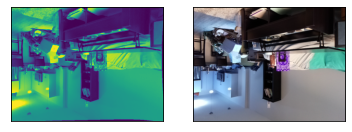

In [27]:
image = cv2.imread(imageToDisp)
imageLeft = image[0:photo_height, 0:image_width,:] 
pair_img = cv2.imread(imageToDisp,0)
imgLeft = pair_img[0:photo_height, 0:image_width]  # Y+H and X+W
imgRight = pair_img[0:photo_height, image_width:photo_width]  # Y+H and X+W

# Implementing calibration data
print('Read calibration data and rectifying stereo pair...')
calibration = StereoCalibration(input_folder='calib_resultA')
rectified_pair = calibration.rectify((imgLeft, imgRight))
dmLeft = rectified_pair[0]
dmRight = rectified_pair[1]
sbm = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_pixels = sbm.compute(dmLeft, dmRight)


array = np.zeros((480,640), "uint8")
# array[185:276,392:460] =  1 #img 1
array[187:270,395:452] =  1 #img 2
# array[184:258,389:443] =  1 #img 3
# array[203:245,330:392] =  1 #img 4

fig, ax = plt.subplots(ncols = 2)
imgLeft = image[0:photo_height, 0:image_width, :]

# bin_img = generateBinaryImg(imgLeft)
bin_img = array
visual = fire_disparity(bin_img, disparity)
I = fire_disparity(bin_img, disparity_pixels)
mean = np.sum(I)/np.count_nonzero(I) #avg disparity of fire pixels

ax[0].imshow(dmLeft)
# ax[0].imshow(stereo_depth_map(rectified_pair),cmap='jet') #cmap='jet'
ax[1].imshow(imageLeft)
print("mean disparity: ", mean)
print("distance: ", distance_to_camera(mean))
[ax[j].get_yaxis().set_visible(False) for j in range(2)]
[ax[j].get_xaxis().set_visible(False) for j in range(2)]
fig.savefig('image.png', dpi = 300, bbox_inches = 'tight', transparent = False)

In [ ]:
print(np.mean(disparity_pixels))